In [1]:
import sys

sys.path.insert(1, "/home/vinicius/storage1/projects/phase_coupling_analysis")

In [2]:
import argparse
import os

import matplotlib.pyplot as plt
import numpy as np
import scipy
import xarray as xr
from config import bands, freqs
from mne.filter import filter_data
from src.metrics.phase import hilbert_decomposition
from src.util import get_dates
from tqdm import tqdm
from util import load_session_data

#### Config

In [3]:
band_id = 0

#### Loading data

In [4]:
data = xr.load_dataarray("data/test_data.nc")

In [5]:
count = 0


def shuffle_along_axis(a, axis):
    idx = np.random.rand(*a.shape).argsort(axis=axis)
    return np.take_along_axis(a, idx, axis=axis)


def create_generalized_surrogate(data, n_boot):
    count = 0
    trials_surr = []
    while count < n_boot:
        out = np.random.choice(
            range(data.sizes["trials"]),
            size=2,
            replace=True,
        )

        if out[0] == out[1]:
            continue
        else:
            trials_surr += [out]
            count = count + 1
    trials_surr = np.stack(trials_surr)

    count = 0
    channels_surr = []
    while count < n_boot:
        out = np.random.choice(
            range(data.sizes["roi"]),
            size=2,
            replace=True,
        )

        if out[0] == out[1]:
            continue
        else:
            channels_surr += [out]
            count = count + 1
    channels_surr = np.stack(channels_surr)

    data_surr = []
    for c_i, c_j, trial_i, trial_j in np.concatenate(
        (channels_surr, trials_surr), axis=1
    ):
        x = data[trial_i, c_i]
        y = data[trial_j, c_j][..., ::-1]
        data_surr += [np.stack((x, y))]

    data_surr = np.stack(data_surr)

    data_surr = xr.DataArray(
        data_surr, dims=("trials", "roi", "times"), coords={"times": data.time.values}
    )

    return data_surr

In [6]:
data_surr = [
    create_generalized_surrogate(data, data.sizes["trials"]) for i in tqdm(range(20))
]

100%|████████████████████████████████████████████████████████| 20/20 [00:03<00:00,  6.01it/s]


### Filter data

In [7]:
temp = []

for f_l, f_h in bands:
    temp += [filter_data(data.values, data.fsample, f_l, f_h, n_jobs=1, verbose=False)]

temp = np.stack(temp, 2)

data = xr.DataArray(
    temp,
    dims=("trials", "roi", "freqs", "times"),
    coords={
        "trials": data.trials,
        "roi": data.roi,
        "freqs": freqs,
        "times": data.time.values,
    },
    attrs=data.attrs,
)

In [8]:
data_surr_filt = []

for data_surr_ in tqdm(data_surr):

    temp = []

    for f_l, f_h in bands:
        temp += [
            filter_data(
                data_surr_.values, data.fsample, f_l, f_h, n_jobs=1, verbose=False
            )
        ]

    temp = np.stack(temp, 2)

    data_surr_filt += [
        xr.DataArray(
            temp,
            dims=("trials", "roi", "freqs", "times"),
            coords={
                "trials": data_surr_.trials,
                "roi": data_surr_.roi,
                "freqs": freqs,
                "times": data_surr_.times.values,
            },
            attrs=data.attrs,
        )
    ]

100%|████████████████████████████████████████████████████████| 20/20 [00:34<00:00,  1.70s/it]


### Compute phase differences

In [9]:
_dims = ("trials", "roi", "freqs", "times")

# for s in range(epoch_data.sizes["epochs"]):
power, phase, phase_diff = hilbert_decomposition(
    data,
    sfreq=data.fsample,
    decim=1,
    times="times",
    roi="roi",
    n_jobs=1,
    verbose=None,
)

power = power.transpose(*_dims)
phase = phase.transpose(*_dims)
phase_diff = phase_diff.transpose(*_dims)

Defining links (n_roi=2; directed=False; net=False, nb_min_links=None)
    Sorting roi names
Computing pairwise phase difference (n_pairs=1)
/home/vinicius/anaconda3/envs/test_env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
100%|█████████████████████████████████████████████████████|  : 1/1 [00:00<00:00,    3.30it/s]


In [12]:
_dims = ("trials", "roi", "freqs", "times")

phase_std_surr = []

for data_surr_ in tqdm(data_surr_filt):

    # for s in range(epoch_data.sizes["epochs"]):
    _, _, phase_diff_surr = hilbert_decomposition(
        data_surr_,
        sfreq=data.fsample,
        decim=1,
        times="times",
        roi="roi",
        n_jobs=1,
        verbose=False,
    )
    
    phase_diff_surr = phase_diff_surr.transpose(*_dims)

    phase_std_surr += [ scipy.stats.circstd(phase_diff_surr, axis=(0, 1, 3)) * 180 / np.pi ]

  0%|                                                                 | 0/20 [00:00<?, ?it/s]Defining links (n_roi=2; directed=False; net=False, nb_min_links=None)
    Sorting roi names
Computing pairwise phase difference (n_pairs=1)

  0%|                                                         |  : 0/1 [00:00<?,       ?it/s]
100%|█████████████████████████████████████████████████████|  : 1/1 [00:00<00:00,    3.49it/s]
  5%|██▊                                                      | 1/20 [00:01<00:27,  1.44s/it]Defining links (n_roi=2; directed=False; net=False, nb_min_links=None)
    Sorting roi names
Computing pairwise phase difference (n_pairs=1)

  0%|                                                         |  : 0/1 [00:00<?,       ?it/s]
100%|█████████████████████████████████████████████████████|  : 1/1 [00:00<00:00,    3.24it/s]
 10%|█████▋                                                   | 2/20 [00:02<00:26,  1.45s/it]Defining links (n_roi=2; directed=False; net=False, nb_min_li

In [14]:
phase_std = scipy.stats.circstd(phase_diff, axis=(0, 1, 3)) * 180 / np.pi
#phase_std_surr = scipy.stats.circstd(phase_diff_surr, axis=(0, 1, 3)) * 180 / np.pi

Text(0.5, 0, 'Frequency [Hz]')

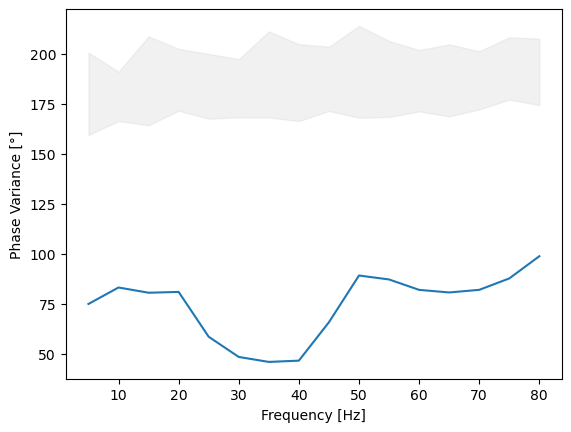

In [22]:
plt.plot(freqs, phase_std)
plt.fill_between(freqs, np.quantile(phase_std_surr, .05, 0), np.quantile(phase_std_surr, .95, 0), alpha=.3, color="lightgray")

plt.ylabel("Phase Variance [°]")
plt.xlabel("Frequency [Hz]")